In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit,KFold,train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,StackingRegressor
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE,SelectKBest,f_regression
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
pd.set_option('display.max_rows', None)

CSV DOSYALARININ YÜKLENMESİ VE TEST DOSYASININ OLUŞTURULMASI

In [2]:
train = pd.read_csv("data/train.csv")
submission = pd.read_csv("data/sample_submission.csv")

submission['merchant_id'] = submission['id'].astype(str).str[6:]
submission['month_id'] = submission['id'].astype(str).str[:6]
submission.drop(columns=['net_payment_count'],inplace=True)
train.drop(columns=['month_id','net_payment_count'],inplace=True)
test = submission.merge(train,on='merchant_id',how='left').drop_duplicates().reset_index(drop=True)
test.to_csv('data/test.csv',index=False)
test["net_payment_count"] = 0

train = pd.read_csv("data/train.csv")
train.insert(0, "id", train["month_id"].astype(str).str.cat(train["merchant_id"].astype(str)))

train["date"] = pd.to_datetime(train["month_id"], format="%Y%m")
train.sort_values("date",inplace=True)
train = train.reset_index(drop=True)

test["date"] = pd.to_datetime(test["month_id"], format="%Y%m")
test.sort_values("date",inplace=True)
test = test.reset_index(drop=True)



In [3]:
train.head()

,id,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date
0,202001merchant_66740,merchant_66740,202001,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_130,Segment - 4,6,2020-01-01
1,202001merchant_12444,merchant_12444,202001,Merchant Source - 1,Settlement Period - 1,Working Type - 2,mcc_153,Segment - 4,3,2020-01-01
2,202001merchant_40154,merchant_40154,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_168,Segment - 4,3,2020-01-01
3,202001merchant_33179,merchant_33179,202001,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_25,Segment - 2,787,2020-01-01
4,202001merchant_16977,merchant_16977,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_31,Segment - 4,5,2020-01-01


In [4]:
train.shape

(291142, 10)

In [5]:
test.head()

,id,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date
0,202310merchant_66957,merchant_66957,202310,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_42,Segment - 4,0,2023-10-01
1,202310merchant_23584,merchant_23584,202310,Merchant Source - 1,Settlement Period - 1,Working Type - 5,mcc_40,Segment - 4,0,2023-10-01
2,202310merchant_66460,merchant_66460,202310,Merchant Source - 2,Settlement Period - 1,Working Type - 3,mcc_96,Segment - 4,0,2023-10-01
3,202310merchant_28101,merchant_28101,202310,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_35,Segment - 2,0,2023-10-01
4,202310merchant_36789,merchant_36789,202310,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_126,Segment - 4,0,2023-10-01


In [7]:
test.shape

(78180, 10)

CHURN CUSTOMERS TESPİTİ VE VERİ SETİNDEN ÇIKARILMASI

In [8]:
churn_sorted = train.sort_values(by=["merchant_id","date"],ascending=[True,False])
latest_transaction_by_merchant = churn_sorted.groupby("merchant_id").first().reset_index()
churn_merchants=latest_transaction_by_merchant.loc[latest_transaction_by_merchant["net_payment_count"] < 1,["merchant_id","net_payment_count"]]
churn_merchants.head()

,merchant_id,net_payment_count
127,merchant_10289,-2
1327,merchant_13091,-1
1414,merchant_13267,0
2768,merchant_16491,-40
4266,merchant_19996,0


In [9]:
churn_merchants.shape

(50, 2)

50 tane şirket churn olmuş. Churn idleri en son test dosyasında sıfırlamak için ayrı bir dfye kaydediyoruz.

In [11]:
churn_merchants_for_submit = churn_merchants
churn_merchants_for_submit.loc[:,"net_payment_count"] = 0
churn_merchants_for_submit.head()

,merchant_id,net_payment_count
127,merchant_10289,0
1327,merchant_13091,0
1414,merchant_13267,0
2768,merchant_16491,0
4266,merchant_19996,0


Churn merchantlar toplam ne kadar işlem yapmış?

In [12]:
train.loc[train["merchant_id"].isin(churn_merchants_for_submit["merchant_id"])].groupby(["merchant_id"])["net_payment_count"].sum().sum()

21726443

100%|██████████| 50/50 [00:01<00:00, 35.51it/s]


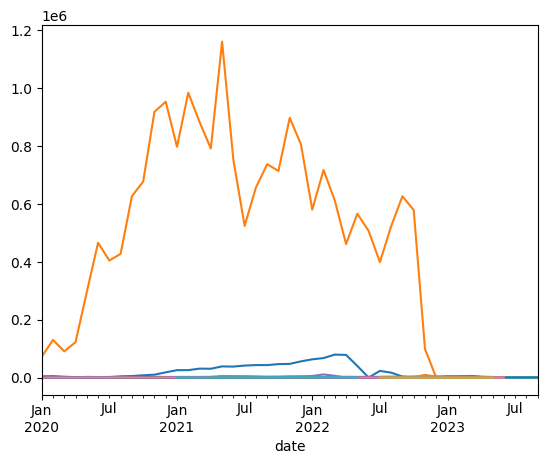

In [19]:
for churned in tqdm(churn_merchants["merchant_id"]):
    train.loc[train["merchant_id"]==churned].groupby("date")["net_payment_count"].sum().plot()

churn merchants incelendiğinde bu işlem sayılarının çoğunun merchant_60635 tarafından yapıldığı ortaya çıkıyor. 

In [13]:
train.loc[train["merchant_id"]=="merchant_60635"].groupby("date")["net_payment_count"].sum().sum()

20555065

<Axes: xlabel='date'>

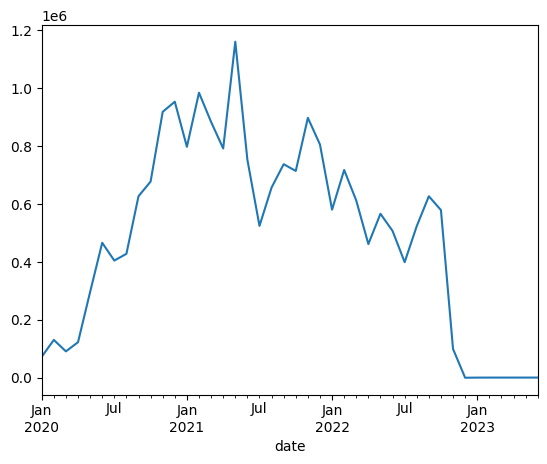

In [20]:
train.loc[train["merchant_id"]=="merchant_60635"].groupby("date")["net_payment_count"].sum().plot()

Veri setindeki toplam işlem sayısınında büyük bir kısmını oluşturuyor.

In [14]:
train["net_payment_count"].sum()

120935787

<Axes: xlabel='date'>

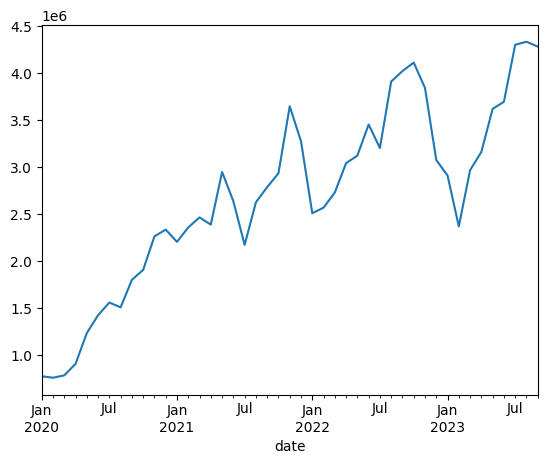

In [15]:
train.groupby("date")["net_payment_count"].sum().plot()

<Axes: ylabel='net_payment_count'>

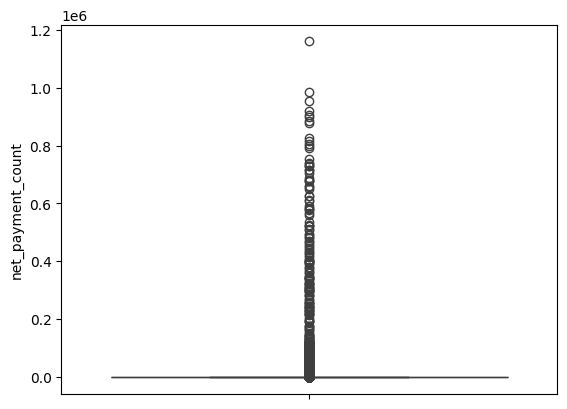

In [16]:
sns.boxplot(train["net_payment_count"])

Target değişkenimiz net payment countun yüksek oranda sağa çarpık olduğunu görüyoruz. merchant_60635 genel dağılımı da etkilemiş.

In [18]:
train.describe().T

,count,mean,min,25%,50%,75%,max,std
month_id,291142.0,202159.68086,202001.0,202103.0,202201.0,202211.0,202309.0,104.214948
net_payment_count,291142.0,415.384201,-1433.0,4.0,6.0,14.0,1160429.0,10820.674338
date,291142,2021-12-22 08:43:56.338281728,2020-01-01 00:00:00,2021-03-01 00:00:00,2022-01-01 00:00:00,2022-11-01 00:00:00,2023-09-01 00:00:00,NaN


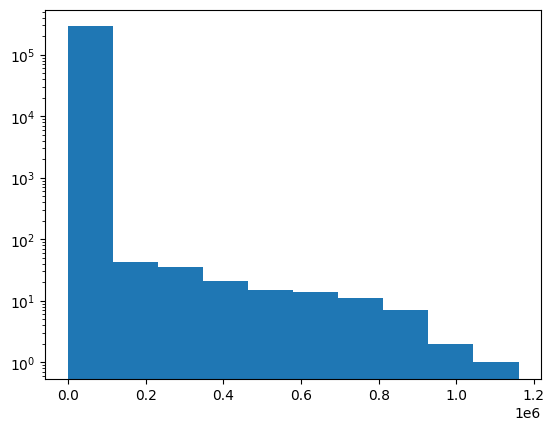

In [24]:
plt.hist(train["net_payment_count"])
plt.yscale('log')

Yüksek sayıda işlem yapan churn olmayan müşterileri incelediğimizde merchant_60635'in etkisi görülüyor.

100%|██████████| 18/18 [00:00<00:00, 34.23it/s]


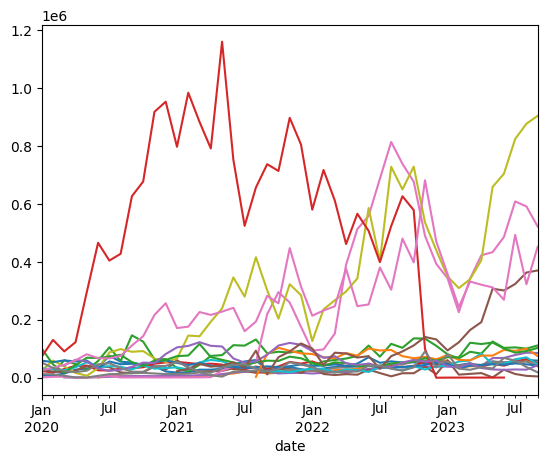

In [21]:
sum_transaction_by_merchant = train.groupby("merchant_id")["net_payment_count"].sum().reset_index()
top_marchants=sum_transaction_by_merchant.loc[sum_transaction_by_merchant["net_payment_count"] > 1000000,["merchant_id","net_payment_count"]]
for top in tqdm(top_marchants["merchant_id"]):
    train.loc[train["merchant_id"]==top].groupby("date")["net_payment_count"].sum().plot()


Train setten churn olan 50 id çıkarılıyor

In [25]:
train=train[~train["merchant_id"].isin(churn_merchants_for_submit["merchant_id"])].reset_index(drop=True)

In [26]:
train["merchant_id"].nunique()

26010

In [27]:
test["merchant_id"].nunique()

26060

Genel ve yüksek oranda işlem yapanların grafikleri incelendiğinde çarpıklık giderilmese bile merhant_60635 in etkisi gideriliyor. Genel yapı korunuyor.

<Axes: xlabel='date'>

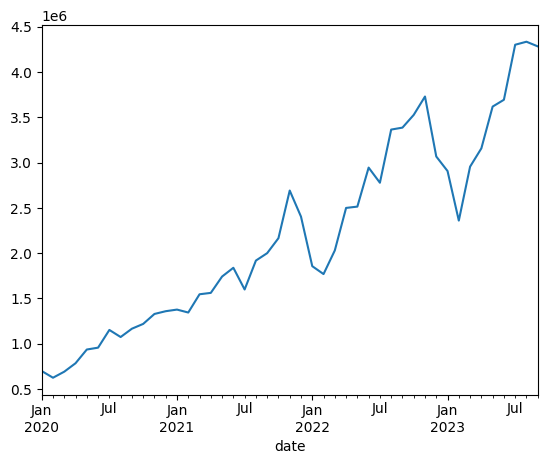

In [28]:
train.groupby("date")["net_payment_count"].sum().plot()

100%|██████████| 17/17 [00:00<00:00, 33.78it/s]


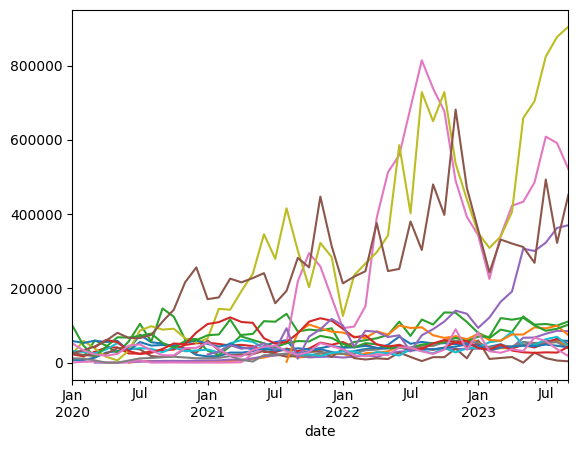

In [30]:
sum_transaction_by_merchant = train.groupby("merchant_id")["net_payment_count"].sum().reset_index()
top_marchants=sum_transaction_by_merchant.loc[sum_transaction_by_merchant["net_payment_count"] > 1000000,["merchant_id","net_payment_count"]]
for top in tqdm(top_marchants["merchant_id"]):
    train.loc[train["merchant_id"]==top].groupby("date")["net_payment_count"].sum().plot()

NEGATİF VERİLERİN SİLİNMESİ

Negatif verilerin sayısı çok fazla olmadığından dağılımı düzeltmek adına 0  ile değiştirildi.

In [31]:
train.loc[train["net_payment_count"] < 0,["net_payment_count"]].sum()

net_payment_count   -4386
dtype: int64

In [32]:
train.loc[train["net_payment_count"] < 0,["net_payment_count"]] = 0

In [33]:
train.describe().T

,count,mean,min,25%,50%,75%,max,std
month_id,290346.0,202159.702796,202001.0,202103.0,202201.0,202211.0,202309.0,104.223633
net_payment_count,290346.0,341.708617,0.0,4.0,6.0,14.0,904587.0,8182.679806
date,290346,2021-12-22 10:50:05.963919104,2020-01-01 00:00:00,2021-03-01 00:00:00,2022-01-01 00:00:00,2022-11-01 00:00:00,2023-09-01 00:00:00,NaN


AYKIRI DEĞER ANALİZİ

In [34]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [35]:
low_limit, up_limit = outlier_thresholds(train,"net_payment_count")

In [36]:
low_limit

-4015.5

In [37]:
up_limit

6700.5

%1 lik dilimdeki müşterilerin işlem sayıları toplam işlem sayısının %82'sini oluşturuyor. Bu nedenle aykırı değerleri çıkarmadım.

In [40]:
total_payment_count=train["net_payment_count"].sum()
percent_1_payment_count = train.loc[train["net_payment_count"]>up_limit,"net_payment_count"].sum()
ratio_of_percent_1 = percent_1_payment_count /total_payment_count
ratio_of_percent_1*100


82.69990151564708